In [1]:
import pandas as pd
import numpy as np
import itertools
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy as sp
from scipy import stats
from scipy.stats import sem, t
from pandas import Series, DataFrame
from statsmodels.stats import weightstats as stests

pd.options.display.float_format = '{:.1f}'.format
df = pd.read_csv('movies.csv')

In [2]:
#keeping only the necessary columns
df = df[['Title', 'Worldwide Gross', 'Production Budget', 'Release Date', 'Major Genre', 'Director', 'Rotten Tomatoes Rating', 'IMDB Rating', 'IMDB Votes']]
#renaming some columns
df.rename(columns = {'Worldwide Gross' : 'Gross', 'Production Budget' : 'Budget', 'Release Date' : 'Date', 'Major Genre' : 'Genre', 'Rotten Tomatoes Rating' : 'RTRating', 'IMDB Rating' : 'IMDBRating', 'IMDB Votes' : 'IMDBVotes'}, inplace = True)

In [3]:
#cropping unnecessary info from Date
df.Date = df['Date'].str.rstrip()
df.Date = df['Date'].str[-2:]

In [4]:
#pruning unwanted rows from Date
df = df[df['Date'].str.isdecimal() == True]

#pruning unwanted rows from Gross
df = df[df['Gross'] != 'Unknown']

In [5]:
#fixing indices after pruning (starting from 1 instead of 0)
df.index = np.arange(1, len(df) + 1)

In [6]:
#fixing Date format
df.Date = pd.to_numeric(df['Date'], errors = 'coerce')
df.Date = df['Date'].map("{:02}".format)
df.Date = df['Date'].apply(lambda x:'20'+x if 0 <= int(x) <= 19 else '19'+x)
df.Date = df['Date'].astype(int)

In [7]:
#converting Gross from str to float
df.Gross = df['Gross'].astype(float)

In [8]:
#fixing scale climax on RTRating
df.RTRating = df['RTRating'].apply(lambda x: x/10)

In [9]:
#to csv
df.to_csv('cleandata_movies.csv', index_label = 'ID')
print(df)

                           Title       Gross     Budget  Date  \
1                 The Land Girls    146083.0  8000000.0  1998   
2         First Love, Last Rites     10876.0   300000.0  1998   
3     I Married a Strange Person    203134.0   250000.0  1998   
4           Let's Talk About Sex    373615.0   300000.0  1998   
5                           Slam   1087521.0  1000000.0  1998   
...                          ...         ...        ...   ...   
3183  Zack and Miri Make a Porno  36851125.0 24000000.0  2008   
3184                      Zodiac  83080084.0 85000000.0  2007   
3185                        Zoom  12506188.0 35000000.0  2006   
3186         The Legend of Zorro 141475336.0 80000000.0  2005   
3187           The Mask of Zorro 233700000.0 65000000.0  1998   

                  Genre         Director  RTRating  IMDBRating  IMDBVotes  
1                   NaN              NaN       nan         6.1     1071.0  
2                 Drama              NaN       nan         6.9     

In [10]:
#making Production Budget and GrossDataframe ---my data mining problem ---
budget_gross_df = df[['Gross', 'Budget']]
budget_gross_df = budget_gross_df.dropna()
print(budget_gross_df)

           Gross     Budget
1       146083.0  8000000.0
2        10876.0   300000.0
3       203134.0   250000.0
4       373615.0   300000.0
5      1087521.0  1000000.0
...          ...        ...
3183  36851125.0 24000000.0
3184  83080084.0 85000000.0
3185  12506188.0 35000000.0
3186 141475336.0 80000000.0
3187 233700000.0 65000000.0

[3186 rows x 2 columns]


In [11]:
#making a genres Dataframe splitting the one column to two (Columns: ID, First, Second)
#helpful 
genres_df = df['Genre'].dropna()
genres_df = genres_df.str.split('/', expand = True)
genres_df.columns = ['First', 'Second']

second_genre = genres_df['Second'].dropna()

print(genres_df)

          First    Second
2         Drama      None
3        Comedy      None
4        Comedy      None
5         Drama      None
8        Comedy      None
...         ...       ...
3183     Comedy      None
3184   Thriller  Suspense
3185  Adventure      None
3186  Adventure      None
3187  Adventure      None

[2925 rows x 2 columns]


In [12]:
#constructing a dictionary for Genre (key = genre : value = number of movies)
genres_hash = {}

for i in genres_df['First']:

    if i not in genres_hash:

        genres_hash[i] = 1

    else:

        genres_hash[i] += 1


for i in second_genre:

    if i not in genres_hash:

        genres_hash[i] = 1

    else:

        genres_hash[i] += 1

In [13]:
#making the Genre Number Dataframe so as to make the bar plot later
genre_numbers_df = pd.DataFrame.from_dict(genres_hash, orient = 'index')
genre_numbers_df.columns = ['Number of Movies']
genre_numbers_df.sort_values('Number of Movies', ascending = False, inplace = True)
genre_numbers_df.reset_index(level = 0, inplace = True)
genre_numbers_df = genre_numbers_df.rename(columns = {'index' : 'Genre'})
print(genre_numbers_df)

              Genre  Number of Movies
0             Drama               789
1            Comedy               674
2            Action               420
3         Adventure               274
4          Thriller               239
5          Suspense               239
6            Horror               219
7   Romantic Comedy               137
8           Musical                53
9       Documentary                43
10          Western                36
11     Black Comedy                36
12          Concert                 5
13      Performance                 5


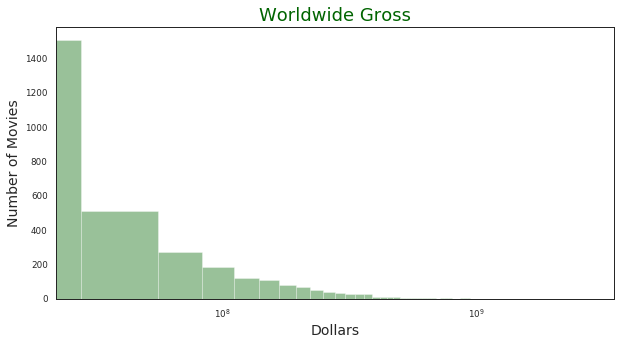

In [14]:
#making Worldwide Gross histogram
sns.set_context('paper')
sns.set_style('white')

gross = df['Gross']

plt.figure(figsize=(10, 5))
sns.distplot( gross, kde = False, color = 'darkgreen', bins = 100)

plt.xscale('log')
plt.title('Worldwide Gross', color = 'darkgreen', fontsize = 18)
plt.xlabel('Dollars', fontsize = 14)
plt.ylabel('Number of Movies', fontsize = 14)

plt.savefig('WorldwideGross_Histogram.png')

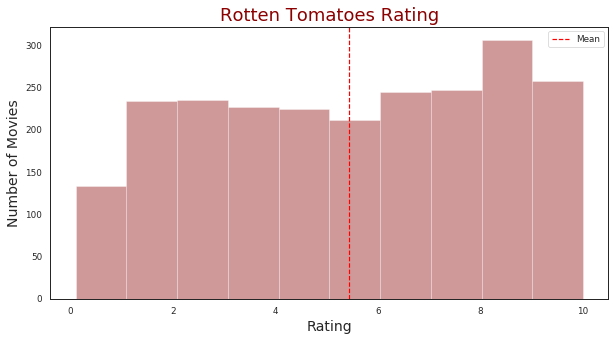

In [15]:
#making Rotten Tomatoes Rating histogram
rtr = df['RTRating'].dropna()

plt.figure(figsize=(10, 5))
sns.distplot(rtr, kde = False, color='darkred', bins = 10)

plt.title('Rotten Tomatoes Rating',color = 'darkred', fontsize = 18)
plt.xlabel('Rating', fontsize = 14)
plt.ylabel('Number of Movies', fontsize = 14)

mean = rtr.mean()
plt.axvline(mean, color='r', linestyle='--')
plt.legend({'Mean':mean})

plt.savefig('RottenTomatoesRating_Histogram.png')

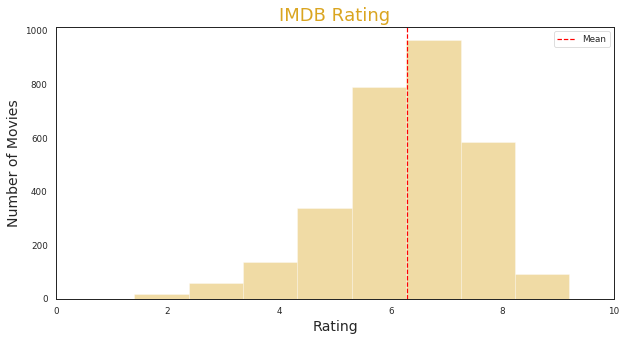

In [16]:
#making IMDB Rating histogram
imdbr = df['IMDBRating'].dropna()

plt.figure(figsize=(10, 5))
sns.distplot(imdbr, kde = False, color='goldenrod', bins = 8)

plt.xlim(0, 10)
plt.title('IMDB Rating',color = 'goldenrod', fontsize = 18)
plt.xlabel('Rating', fontsize = 14)
plt.ylabel('Number of Movies', fontsize=14)

mean = imdbr.mean()
plt.axvline(mean, color='r', linestyle='--')
plt.legend({'Mean':mean})

plt.savefig('IMDBRating_Histogram.png')

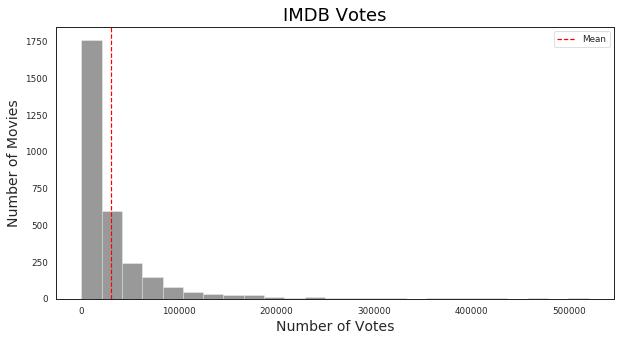

In [17]:
#making IMDB Votes histogram
imdbv = df['IMDBVotes'].dropna()

plt.figure(figsize=(10, 5))
sns.distplot(imdbv, kde = False, color = 'black', bins = 25)

plt.title('IMDB Votes',color = 'black', fontsize = 18)
plt.xlabel('Number of Votes', fontsize = 14)
plt.ylabel('Number of Movies', fontsize = 14)

mean = imdbv.mean()
plt.axvline(mean, color='r', linestyle='--')
plt.legend({'Mean':mean})

plt.savefig('IMDBVotes_Histogram.png')

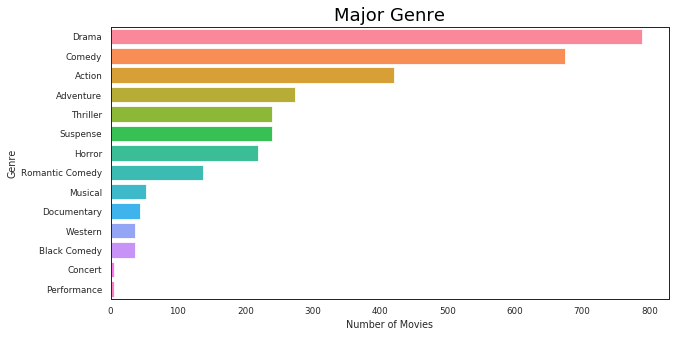

In [18]:
#making Genres bar plot
plt.figure(figsize=(10, 5))
sns.barplot(x = 'Number of Movies', y = 'Genre', saturation = 1, data = genre_numbers_df)

plt.title('Major Genre', color = 'black', fontsize = 18)

plt.savefig('num_movie_genre_barplot.png')

In [19]:
#merging Gross with IMDBVotes into one DataFrame
gross_votes_df = pd.merge(pd.DataFrame(gross), pd.DataFrame(imdbv), left_index = True, right_index = True)
print(gross_votes_df)

           Gross  IMDBVotes
1       146083.0     1071.0
2        10876.0      207.0
3       203134.0      865.0
5      1087521.0      165.0
7        44705.0    15133.0
...          ...        ...
3182  98690286.0    81629.0
3183  36851125.0    55687.0
3185  12506188.0     7424.0
3186 141475336.0    21161.0
3187 233700000.0     4789.0

[2981 rows x 2 columns]


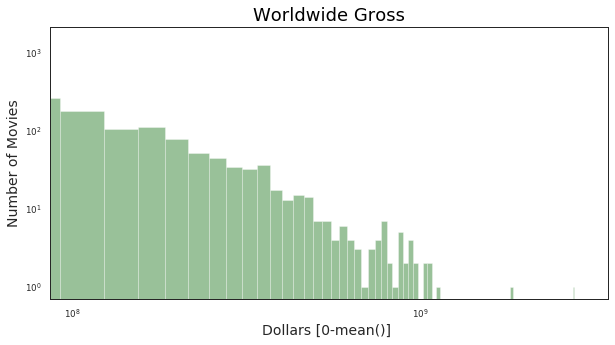

In [20]:
sns.set_style('white')

m = gross_votes_df['Gross'].mean()

plt.figure(figsize=(10, 5))
sns.distplot(gross_votes_df['Gross'], kde = False, color = 'darkgreen', label = 'Gross', bins = 90)

plt.xscale('log')
plt.yscale('log')
plt.xlim(m)
#.mean(skipna = True)

plt.title('Worldwide Gross',color = 'black', fontsize = 18)
plt.xlabel('Dollars [0-mean()] ', fontsize = 14)
plt.ylabel('Number of Movies', fontsize = 14)

plt.savefig('Grosslog_Histogram.png')

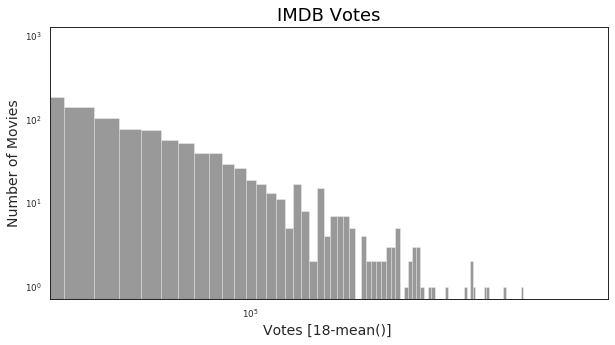

In [21]:
m = gross_votes_df['IMDBVotes'].mean()

plt.figure(figsize=(10, 5))
sns.distplot(gross_votes_df['IMDBVotes'] , kde = False, color = 'black', label = 'IMDBVotes', bins = 80)

plt.xscale('log')
plt.yscale('log')
plt.xlim(m)

plt.title('IMDB Votes',color = 'black', fontsize = 18)
plt.xlabel('Votes [18-mean()] ', fontsize = 14)
plt.ylabel('Number of Movies', fontsize = 14)

plt.savefig('Voteslog_Histogram.png')

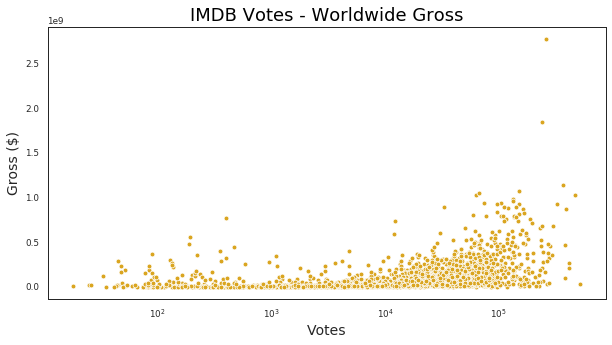

In [22]:
#making Worldwide Gross and IMDB Votes Scatterplot

plt.figure(figsize=(10, 5))
sns.scatterplot(x = 'IMDBVotes', y = 'Gross', data = gross_votes_df, facecolor = 'goldenrod' )

plt.xscale('log')
plt.title('IMDB Votes - Worldwide Gross',color = 'black', fontsize = 18)
plt.xlabel('Votes', fontsize = 14)
plt.ylabel('Gross ($)', fontsize = 14)

plt.savefig('VotesGross_Scatterplot.png')

In [23]:
#Pearson Correlation Coefficient: Worldwide Gross and IMDB Votes
gross_votes_df.corr(method = 'pearson')

,Gross,IMDBVotes
Gross,1.0,0.6
IMDBVotes,0.6,1.0


In [24]:
#Spearman Correlation Coefficient: Worldwide Gross and IMDB Votes
gross_votes_df.corr(method = 'spearman')

,Gross,IMDBVotes
Gross,1.0,0.7
IMDBVotes,0.7,1.0


In [25]:
#2 sample z-test: Worldwide Gross and IMDB Votes
print('H0: Movies are more popular online, than in the cinema.\n ')

ztest, pval = stests.ztest(gross_votes_df['IMDBVotes'], x2 = gross_votes_df['Gross'], value = 0, alternative = 'larger')
print('p-value: ', pval)

if pval<0.05:
    
    print('\nReject Null Hypothesis (H0)')

else:
    
    print('\nAccept Null Hypothesis (H0)')

H0: Movies are more popular online, than in the cinema.
 
p-value:  1.0

Accept Null Hypothesis (H0)


In [26]:
#concatenating RTRating with IMDBRating into one DataFrame
rtr_imdbr_df = pd.concat([pd.DataFrame(rtr), pd.DataFrame(imdbr)], axis =1)
rtr_imdbr_df.dropna(inplace=True)
print(rtr_imdbr_df)

      RTRating  IMDBRating
5          6.2         3.4
9          2.5         5.8
10         8.6         7.0
11         8.1         7.0
12         8.4         7.5
...        ...         ...
3182       8.9         7.8
3183       6.5         7.0
3185       0.3         3.4
3186       2.6         5.7
3187       8.2         6.7

[2256 rows x 2 columns]


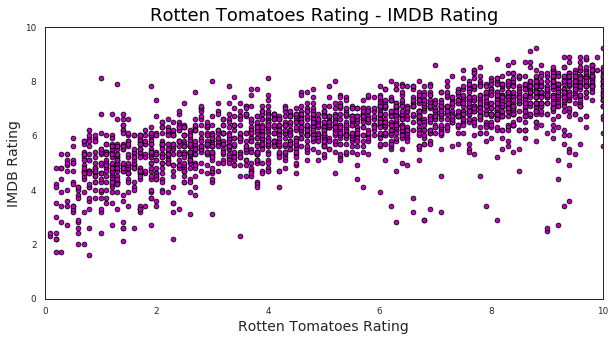

In [27]:
#making RTRating and IMDBRating Scatterplot
plt.figure(figsize=(10, 5))
sns.scatterplot(x = 'RTRating', y='IMDBRating', data = rtr_imdbr_df, facecolor = 'm', edgecolor = 'black')

plt.title('Rotten Tomatoes Rating - IMDB Rating',color = 'black', fontsize = 18)
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel('Rotten Tomatoes Rating', fontsize = 14)
plt.ylabel('IMDB Rating', fontsize = 14)

plt.savefig('RTR_IMDB_Ratings_Scatterplot.png')

In [28]:
#Pearson Correlation Coefficient: RTRating and IMDBRating
rtr_imdbr_df.corr(method = 'pearson')

,RTRating,IMDBRating
RTRating,1.0,0.7
IMDBRating,0.7,1.0


In [29]:
#Spearman Correlation Coefficient: RTRating and IMDBRating
rtr_imdbr_df.corr(method = 'spearman')

,RTRating,IMDBRating
RTRating,1.0,0.8
IMDBRating,0.8,1.0


In [30]:
#2 sample z-test1:  RTRating and IMDBRating
print('H0: People in Rotten Tomatoes and  IMDB vote similarly.\n ')

ztest, pval = stests.ztest(rtr_imdbr_df['RTRating'], x2 = rtr_imdbr_df['IMDBRating'], value = 0 , alternative = 'two-sided')
print('p-value: ', pval)

if pval<0.05:
    
    print('\nReject Null Hypothesis (H0)')

else:
    
    print('\nAccept Null Hypothesis (H0)')

H0: People in Rotten Tomatoes and  IMDB vote similarly.
 
p-value:  7.21302915029273e-43

Reject Null Hypothesis (H0)


In [31]:
#2 sample z-test2:  RTRating and IMDBRating
print('H1: People in Rotten Tomatoes vote higher than in IMDB.\n ')

ztest, pval = stests.ztest(rtr_imdbr_df['RTRating'], x2 = rtr_imdbr_df['IMDBRating'], value = 0 , alternative = 'larger')
print('p-value: ', pval)

if pval<0.05:
    
    print('\nReject Null Hypothesis (H1)')

else:
    
    print('\nAccept Null Hypothesis (H1)')

H1: People in Rotten Tomatoes vote higher than in IMDB.
 
p-value:  1.0

Accept Null Hypothesis (H1)


In [32]:
#making one DataFrame with Genres (1 and 2 ) and Gross
gross_genre_df = pd.DataFrame(df['Gross'])
gross_genre_df['Genre1'] = genres_df[['First']]
gross_genre_df.dropna(inplace = True)
gross_genre_df['Genre2'] = genres_df[['Second']]


In [33]:
#Grouping by genres and finding mean gross (in both genre dfs), then putting them all in one DataFrame
m_gross_genre1_df = gross_genre_df.groupby('Genre1').mean().reset_index()
m_gross_genre2_df = gross_genre_df.groupby('Genre2').mean().reset_index()
m_gross_genre2_df = m_gross_genre2_df.rename(columns = {'Genre2' : 'Genre1'})

m_gross_genre1_df = m_gross_genre1_df.append(m_gross_genre2_df, ignore_index = True)
m_gross_genre1_df = m_gross_genre1_df.rename(columns = {'Genre1' : 'Genre', 'Gross' : 'Mean Gross'})

m_gross_genre1_df.sort_values('Mean Gross', ascending = False, inplace = True)
print(m_gross_genre1_df)


              Genre  Mean Gross
1         Adventure 241171385.5
0            Action 143894309.0
9   Romantic Comedy  86617850.5
10         Thriller  80588648.9
13         Suspense  80588648.9
3            Comedy  74753782.3
8           Musical  73676198.1
7            Horror  60829583.4
6             Drama  51300594.4
11          Western  36149254.2
4           Concert  30724401.8
12      Performance  30724401.8
2      Black Comedy  22907553.5
5       Documentary  16254521.0


In [34]:
#Grouping by genres and finding std gross (in both genre dfs), then putting them all in one DataFrame
std_gross_genre1_df = gross_genre_df.groupby('Genre1').std().reset_index()
std_gross_genre2_df = gross_genre_df.groupby('Genre2').std().reset_index()
std_gross_genre2_df = std_gross_genre2_df.rename(columns = {'Genre2' : 'Genre1'})

std_gross_genre1_df = std_gross_genre1_df.append(std_gross_genre2_df, ignore_index = True)
std_gross_genre1_df = std_gross_genre1_df.rename(columns = {'Genre1' : 'Genre', 'Gross' : 'Std Gross'})
print(std_gross_genre1_df)

              Genre   Std Gross
0            Action 205869314.1
1         Adventure 270085627.4
2      Black Comedy  31426516.0
3            Comedy 103454376.6
4           Concert  26028676.2
5       Documentary  40051559.8
6             Drama  87834907.6
7            Horror  78287555.3
8           Musical  91998640.2
9   Romantic Comedy 106415023.5
10         Thriller 157604416.8
11          Western  72338353.3
12      Performance  26028676.2
13         Suspense 157604416.8


In [35]:
#calculating the confidence intervals ci lower and ci upper 
conf_int = stats.norm.interval(0.95, loc = m_gross_genre1_df['Mean Gross'], scale = std_gross_genre1_df['Std Gross']/np.sqrt(std_gross_genre1_df['Std Gross'].count()))
conf_int = np.array(conf_int)
print(conf_int)

[[ 1.33332426e+08  2.41740508e+06  7.01559372e+07  2.63969281e+07
   6.69542450e+07  5.37738778e+07  2.76663052e+07  1.98208076e+07
   3.10964507e+06 -1.95933197e+07 -5.18323234e+07 -7.16804866e+06
   9.27314969e+06 -6.63022043e+07]
 [ 3.49010345e+08  2.85371213e+08  1.03079764e+08  1.34780370e+08
   9.42230527e+07  9.57336868e+07  1.19686091e+08  1.01838359e+08
   9.94915437e+07  9.18918281e+07  1.13281127e+08  6.86168523e+07
   3.65419574e+07  9.88112462e+07]]


In [49]:
# putting ci lower and ci upper in or m_gross_genre1_df DataFrame
# ready to make the barplot with confidence intervals
m_gross_genre1_df['Bottom Error Ci'] = conf_int[0]
m_gross_genre1_df['Top Error Ci'] = conf_int[1]


m_gross_genre1_df.reset_index(drop = True, inplace = True)


m_gross_genre1_df['Bottom Error Ci'] = m_gross_genre1_df['Bottom Error Ci'].mask(m_gross_genre1_df['Bottom Error Ci'] < 0, 0)
yerror = [m_gross_genre1_df['Top Error Ci'] - m_gross_genre1_df['Mean Gross'], m_gross_genre1_df['Mean Gross'] - m_gross_genre1_df['Bottom Error Ci']]



print(m_gross_genre1_df)
print(yerror)



              Genre  Mean Gross  Bottom Error Ci  Top Error Ci
0         Adventure 241171385.5      133332425.6   349010345.5
1            Action 143894309.0        2417405.1   285371212.8
2   Romantic Comedy  86617850.5       70155937.2   103079763.8
3          Thriller  80588648.9       26396928.1   134780369.6
4          Suspense  80588648.9       66954245.0    94223052.7
5            Comedy  74753782.3       53773877.8    95733686.8
6           Musical  73676198.1       27666305.2   119686090.9
7            Horror  60829583.4       19820807.6   101838359.2
8             Drama  51300594.4        3109645.1    99491543.7
9           Western  36149254.2              0.0    91891828.1
10          Concert  30724401.8              0.0   113281127.0
11      Performance  30724401.8              0.0    68616852.3
12     Black Comedy  22907553.5        9273149.7    36541957.4
13      Documentary  16254521.0              0.0    98811246.2
[0    107838959.9
1    141476903.9
2     16461913.3
3  

ValueError: The lengths of the data (10) and the error 14 do not match

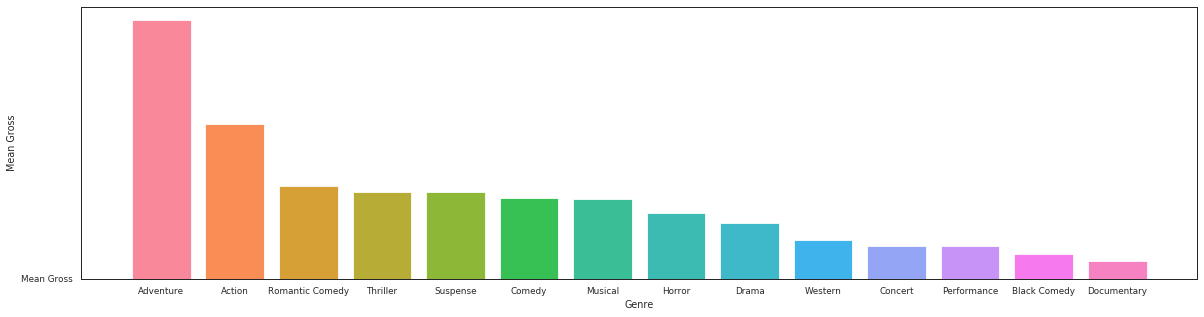

In [47]:
#making the barplot of Mean Worldwide Gross per Genre
plt.figure(figsize=(20, 5))
sns.barplot(x = 'Genre', y = 'Mean Gross', saturation = 1, data = m_gross_genre1_df)

plt.errorbar(x = 'Genre', y = 'Mean Gross', yerr = yerror, c = 'r')

plt.title('Mean Worldwide Gross per Genre', color = 'black', fontsize = 18)
plt.xlabel('Genre', fontsize = 14)
plt.ylabel('Mean Worldwide Gross', fontsize = 14)

plt.savefig('mean_gross_genre_barplot.png')


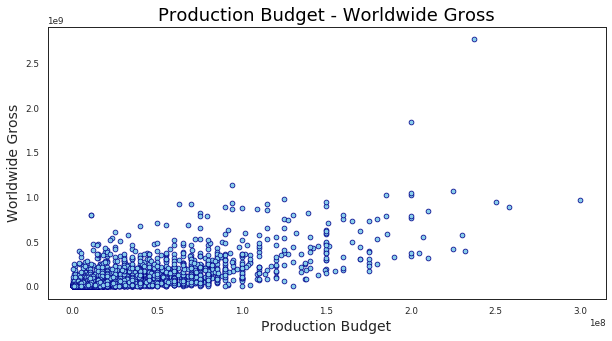

In [48]:
#making Production Budget and Worldwide Gross Scatterplot ----my data mining problem------
plt.figure(figsize=(10, 5))
sns.scatterplot(x = 'Budget', y='Gross', data = budget_gross_df, facecolor = 'skyblue', edgecolor ='darkblue')

plt.title('Production Budget - Worldwide Gross',color = 'black', fontsize = 18)

plt.xlabel('Production Budget', fontsize = 14)
plt.ylabel('Worldwide Gross', fontsize = 14)

plt.savefig('Budget_Gross_Scatterplot.png')


In [46]:
#Pearson Correlation Coefficient: Production Budget and Worldwide Gross
budget_gross_df.corr(method = 'pearson')

,Gross,Budget
Gross,1.0,0.7
Budget,0.7,1.0


In [47]:
#Spearman Correlation Coefficient: Production Budget and Worldwide Gross
budget_gross_df.corr(method = 'spearman')

,Gross,Budget
Gross,1.0,0.7
Budget,0.7,1.0


In [48]:
#2 sample z-test1: Production Budget and Worldwide Gross
print('H0: Grosses are larger than budgets invested.\n ')

ztest, pval = stests.ztest(budget_gross_df['Gross'], x2 = budget_gross_df['Budget'], value = 0 , alternative = 'larger')
print('p-value: ', pval)

if pval<0.05:
    
    print('\nReject Null Hypothesis (H0)')

else:
    
    print('\nAccept Null Hypothesis (H0)')

H0: Grosses are larger than budgets invested.
 
p-value:  1.8468088059599744e-88

Reject Null Hypothesis (H0)


In [49]:
#2 sample z-test2: Production Budget and Worldwide Gross
print('H1: Grosses are smaller than budgets invested.\n ')

ztest, pval = stests.ztest(budget_gross_df['Gross'], x2 = budget_gross_df['Budget'], value = 0 , alternative = 'smaller')
print('p-value: ', pval)

if pval<0.05:
    
    print('\nReject Null Hypothesis (H1)')

else:
    
    print('\nAccept Null Hypothesis (H1)')

H1: Grosses are smaller than budgets invested.
 
p-value:  1.0

Accept Null Hypothesis (H1)


In [50]:
# making the DataFrame for the mean() RTRating and mean() IMDBRating per decade
ratings_dates_df = df[['RTRating', 'IMDBRating', 'Date']]
ratings_dates_df = ratings_dates_df.rename(columns = {'RTRating' : 'Rotten Tomatoes', 'IMDBRating': 'IMDB'})
ratings_dates_df = ratings_dates_df.groupby((ratings_dates_df.Date//10)*10).mean()

ratings_dates_df = ratings_dates_df[['Rotten Tomatoes', 'IMDB']]
ratings_dates_df.reset_index(level = 0, inplace = True)
ratings_dates_df = ratings_dates_df.rename(columns = {'Date' : 'Decade'})

ratings_dates_df = pd.melt(ratings_dates_df, id_vars = 'Decade', var_name = 'Website', value_name = 'Rating')
print(ratings_dates_df)

    Decade          Website  Rating
0     1920  Rotten Tomatoes     6.9
1     1930  Rotten Tomatoes     9.7
2     1940  Rotten Tomatoes     9.3
3     1950  Rotten Tomatoes     8.1
4     1960  Rotten Tomatoes     8.1
5     1970  Rotten Tomatoes     7.6
6     1980  Rotten Tomatoes     6.8
7     1990  Rotten Tomatoes     5.5
8     2000  Rotten Tomatoes     4.8
9     2010  Rotten Tomatoes     5.1
10    1920             IMDB     7.8
11    1930             IMDB     7.4
12    1940             IMDB     7.4
13    1950             IMDB     7.1
14    1960             IMDB     7.2
15    1970             IMDB     6.8
16    1980             IMDB     6.3
17    1990             IMDB     6.2
18    2000             IMDB     6.2
19    2010             IMDB     6.6


<Figure size 720x360 with 0 Axes>

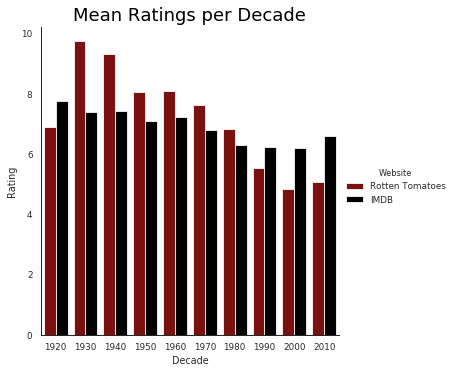

In [51]:
#creating catplot for mean ratings per decade
plt.figure(figsize=(10, 5))
colors = ['darkred', 'black']
palette = sns.color_palette(colors)
sns.catplot(x = 'Decade', y = 'Rating', hue = 'Website', data = ratings_dates_df, palette = palette, kind = 'bar')

plt.title('Mean Ratings per Decade', color = 'black', fontsize = 18)

plt.savefig('ratings_decade_catplot.png')

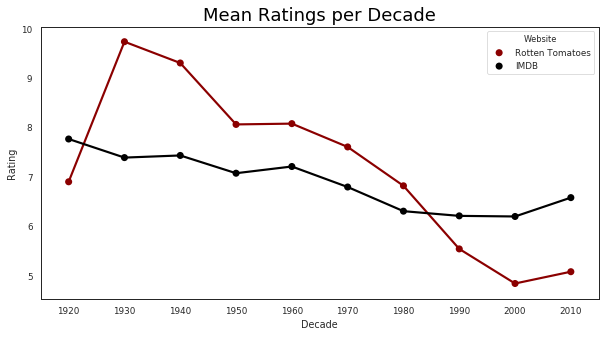

In [52]:
#creating pointplot for mean ratings per decade
plt.figure(figsize=(10, 5))
colors = ['darkred', 'black']
palette = sns.color_palette(colors)
sns.pointplot(x = 'Decade', y = 'Rating', hue = 'Website', data = ratings_dates_df, palette = palette, kind = 'point')

plt.title('Mean Ratings per Decade', color = 'black', fontsize = 18)

plt.savefig('ratings_decade_pointplot.png')

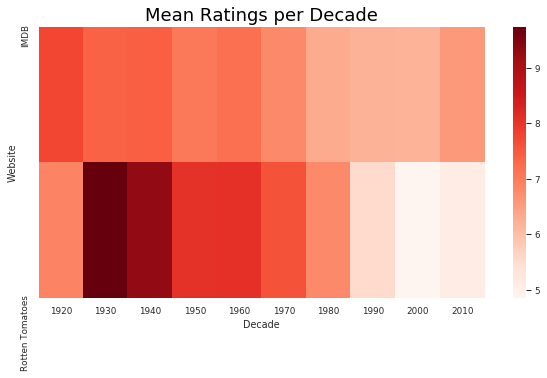

In [53]:
#creating scatterplot for mean ratings per decade
plt.figure(figsize=(10, 5))
sns.heatmap(ratings_dates_df.pivot('Website', 'Decade', 'Rating'), cmap='Reds')

plt.title('Mean Ratings per Decade', color = 'black', fontsize = 18)

plt.savefig('ratings_decade_heatmap.png')